In [1]:
from detector import Detector
import glob
import matplotlib.pyplot as plt
import pandas as pd
import os
import json

test_text = '''
Do you have a problem that you are struggling to solve? Why don't you ask your friends for advice? When people ask for advice on solving a problem, often times they speak to more than one person. This is because different views are better for figuring out a tough problem, many opinions are better than one, and other people may have experienced a problem like yours and may be able to help you in making better decisions.
'''

E:\Python_Projects\PrismAI\env\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
C:\Users\Nutzer\AppData\Local\Temp\ipykernel_884\301221107.py:4: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [28]:
dataset_path = "E:\\Python_Projects\\PrismAI\\data"

def get_essays(label, take):
    all_files = glob.glob(os.path.join(dataset_path, "*.csv"))
    df = None
    for filename in all_files:
        df = pd.concat([df, pd.read_csv(filename)[['text', 'label']]])
    print(f'Found {len(df)} essays.')

    # As a first step, we want to inject AI written sentences into human essays
    # and see if we can sort them out later again
    # 1 = AI generated, 0 = human written
    filtered_df = df[df['label'] == label].sort_index().head(take)
    filtered_essays = filtered_df['text'].tolist()
    print(f'Processing {len(filtered_essays)} filtered essays.')
    return filtered_essays

# EDA

I'm trying to find patterns in the results of the detector.

In [29]:
detector = Detector()
print('Detector inited')

Created model gpt2 to device cpu
Model ensemble: ['gpt2']
Detector inited


## Testing

In [30]:
ai_essays = get_essays(1, 10)
hu_essays = get_essays(0, 10)

Found 159456 essays.
Processing 10 filtered essays.
Found 159456 essays.
Processing 10 filtered essays.


In [31]:
def analyse_essays(essays):
    num_plots_per_row = 3
    num_rows = len(essays)
    
    # Create subplots with specified layout
    fig, axs = plt.subplots(num_rows, num_plots_per_row, figsize=(15, 5 * num_rows))
    
    # Flatten the axs array to make it easier to index
    axs = axs.flatten()
    
    for idx, essay in enumerate(essays):
        output = detector.detect(essay, sample_rate=3, sample_sequence_length=16)[0]
        
        for sample_idx, sample in enumerate(output['sample_results']):
            steps = sample['model_outputs']['steps']
            steps.sort(key=lambda x: x['step'])
            target_probs = [step['target_prob'] for step in steps]
            target_labels = [step['target'] for step in steps]  # Extract target labels

            # Plot the target_prob values
            axs[idx * num_plots_per_row + sample_idx].plot(target_probs)
            axs[idx * num_plots_per_row + sample_idx].set_title(f'Essay {idx + 1}, Sample {sample_idx + 1}')
            axs[idx * num_plots_per_row + sample_idx].set_xlabel('Step')
            axs[idx * num_plots_per_row + sample_idx].set_ylabel('target_prob')
            
            # Set x-axis tick labels to target labels
            axs[idx * num_plots_per_row + sample_idx].set_xticks(range(len(target_labels)))
            axs[idx * num_plots_per_row + sample_idx].set_xticklabels(target_labels, rotation=45, ha='right')  # Adjust rotation and alignment
        
        # Add a row divider
        axs[(idx + 1) * num_plots_per_row - 1].axhline(y=0, color='black', linewidth=2)
    
    # Adjust layout to prevent overlapping
    plt.tight_layout()
    
    # Show the plots
    plt.show()

Using gpt2 ===

Sampling round number 1 for gpt2.
Context sample: There are alot reasons to keep our the despised method of choosing the President. The First reason is because Certainty of Outcome, in the text its states that "The reason is that the winning candidate's share of the Electoral College invariably exceeds his share of the popular vote. Another example from the text is "Obama, he recieved 61.7 percent of the electoral vote compared to only 51.3 percent of the popular votes cast for him and Romney... because all of the states award electoral votes on a winner-take-all basis.

Another reason is that the Electiral College requires a presidential candidate to have trans-regional appeal,in that case, no region has enough electoral votes to elect a president, a solid regional favorite such as Romney was in the South, has no reason to campaign in those states because of the poor economy and because its not a wealthy state, he wont be able to campaign heavily. So he left with no vo

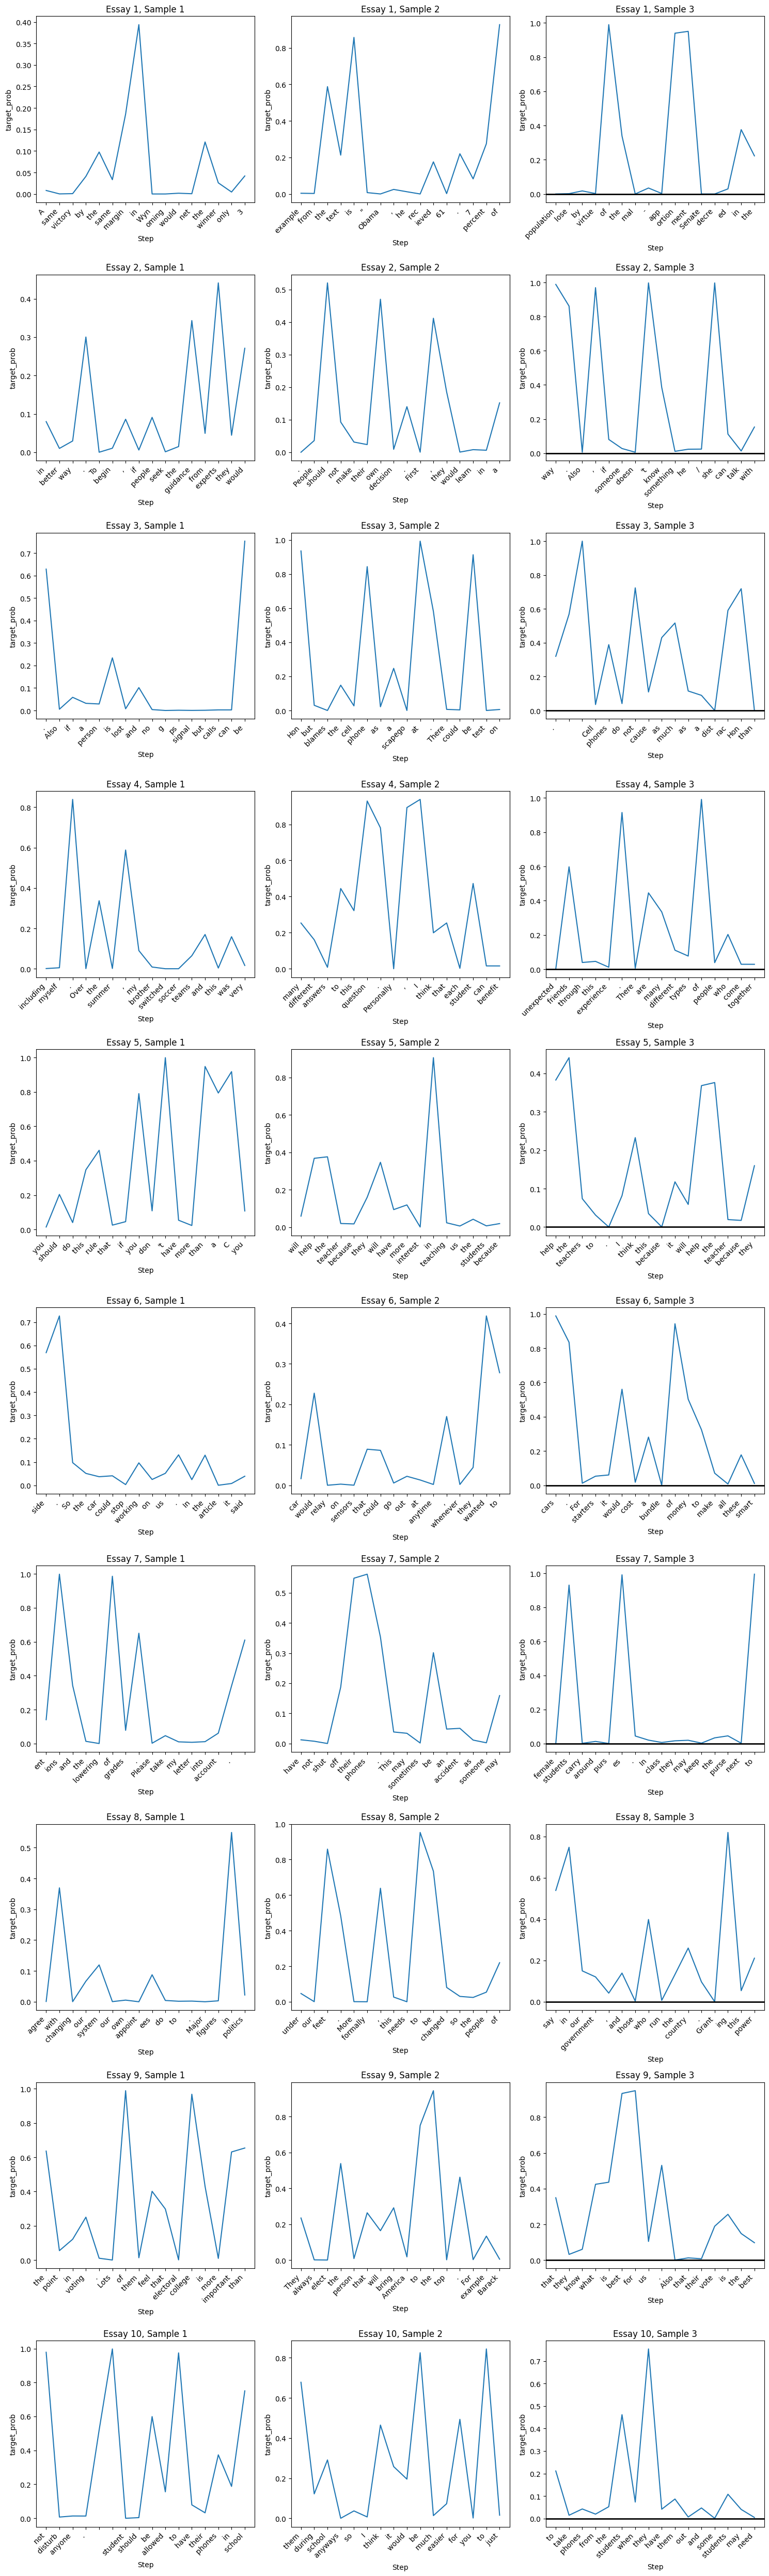

In [33]:
analyse_essays(hu_essays)